In [ ]:
#| default_exp core.schedule

In [ ]:
#| export
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from fastcore.basics import *
from fastai.callback.schedule import *
import math
from typing import Callable

In [ ]:
#| include: false
from fastai.vision.all import *
from nbdev.showdoc import *
%config InlineBackend.figure_format = 'retina'

In [ ]:
#| export
class Schedule():
    "Base class to create schedules that return progress (0→1)"
    def __init__(self,
                 sched_func: Callable,  # Function that computes progress at given training percentage
                 start_pct: float = 0., # Percentage of training to start schedule
                 end_pct: float = 1.,   # Percentage of training to end schedule
                 start_val: float = 0., # Starting value for progress range
                 end_val: float = 1.    # Ending value for progress range
    ):
        "Base class to create schedules for pruning, regularization, distillation, etc."
        store_attr()
        self._current_progress = start_val
        self._previous_progress = start_val

    def progress(self, pct_train: float) -> float:
        "Return progress value based on training progress"
        if pct_train < self.start_pct:
            self._current_progress = self.start_val
        elif pct_train >= self.end_pct:
            self._current_progress = self.sched_func(self.start_val, self.end_val, 1.)
        else:
            normalized = (pct_train - self.start_pct) / (self.end_pct - self.start_pct)
            self._current_progress = self.sched_func(self.start_val, self.end_val, normalized)
        return self._current_progress

    @property
    def changed(self) -> bool:
        "Check if progress changed since last step"
        return self._previous_progress != self._current_progress

    # Backward compatibility alias
    @property
    def pruned(self) -> bool:
        "Deprecated: use `.changed` instead"
        return self.changed

    def after_step(self) -> None:
        "Update previous progress after action applied"
        self._previous_progress = self._current_progress

    # Backward compatibility alias
    def after_pruned(self) -> None:
        "Deprecated: use `after_step()` instead"
        self.after_step()

    def reset(self) -> None:
        "Reset to initial state"
        self._current_progress = self.start_val
        self._previous_progress = self.start_val

    def plot(self,
             target: float = 100,    # Target value to visualize (e.g., sparsity percentage)
             num_points: int = 1000  # Number of points to plot
    ) -> None:
        "Plot the schedule showing how target value changes over training"
        pcts = np.linspace(0, 1, num_points)
        values = [self.progress(p) * target for p in pcts]
        fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=100)
        plt.plot(pcts, values, c='teal', linewidth=2)
        plt.xlabel('training iterations (Normalized)')
        plt.ylabel('value')
        self.reset()

In [ ]:
show_doc(Schedule)

Found permutation search CUDA kernels
[ASP][Info] permutation_search_kernels can be imported.


---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L17){target="_blank" style="float:right; font-size:smaller"}

### Schedule

```python

def Schedule(
    sched_func:Callable, # Function that computes progress at given training percentage
    start_pct:float=0.0, # Percentage of training to start schedule
    end_pct:float=1.0, # Percentage of training to end schedule
    start_val:float=0.0, # Starting value for progress range
    end_val:float=1.0, # Ending value for progress range
):


```

*Base class to create schedules that return progress (0→1)*

The `Schedule` class returns progress values from 0→1 by default, enabling the same schedule to work for sparsification, pruning, regularization, and distillation weight.

**Key Method:** `schedule.progress(pct_train)` returns how far along the schedule has progressed.

**Parameters:**
- `sched_func`: the function that determines the progression curve (e.g., linear, cosine, AGP)
- `start_pct`: training percentage at which the schedule begins (default: 0.0)
- `end_pct`: training percentage at which the schedule completes (default: 1.0)
- `start_val`: starting value of the progress range (default: 0.0)
- `end_val`: ending value of the progress range (default: 1.0)

**Usage:**
```python
# Get current value by multiplying target by progress
progress = schedule.progress(pct_train)
current_sparsity = target_sparsity * progress
current_weight = target_weight * progress
```

The `start_val`/`end_val` parameters enable **schedule composition**: chain multiple schedules where each picks up from where the previous one left off. See the [Composing Schedules](#composing-schedules) section below.

## One-Shot

The easiest schedule is the one-shot pruning, i.e. prune the network once. This can be done by simply returning the desired sparsity value. The moment when you want to prune will be controlled by the `start_epoch` argument in the `SparsifyCallback`.

In [ ]:
#| export
def sched_oneshot(
    start: float, # Starting sparsity level
    end: float,   # Target sparsity level
    pos: float    # Current position in schedule (0-1)
) -> float:
    "One-shot pruning: jump directly to target sparsity"
    return end

one_shot = Schedule(sched_oneshot, start_pct=0.5)

In [ ]:
show_doc(sched_oneshot)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L81){target="_blank" style="float:right; font-size:smaller"}

### sched_oneshot

```python

def sched_oneshot(
    start:float, # Starting sparsity level
    end:float, # Target sparsity level
    pos:float, # Current position in schedule (0-1)
)->float:


```

*One-shot pruning: jump directly to target sparsity*

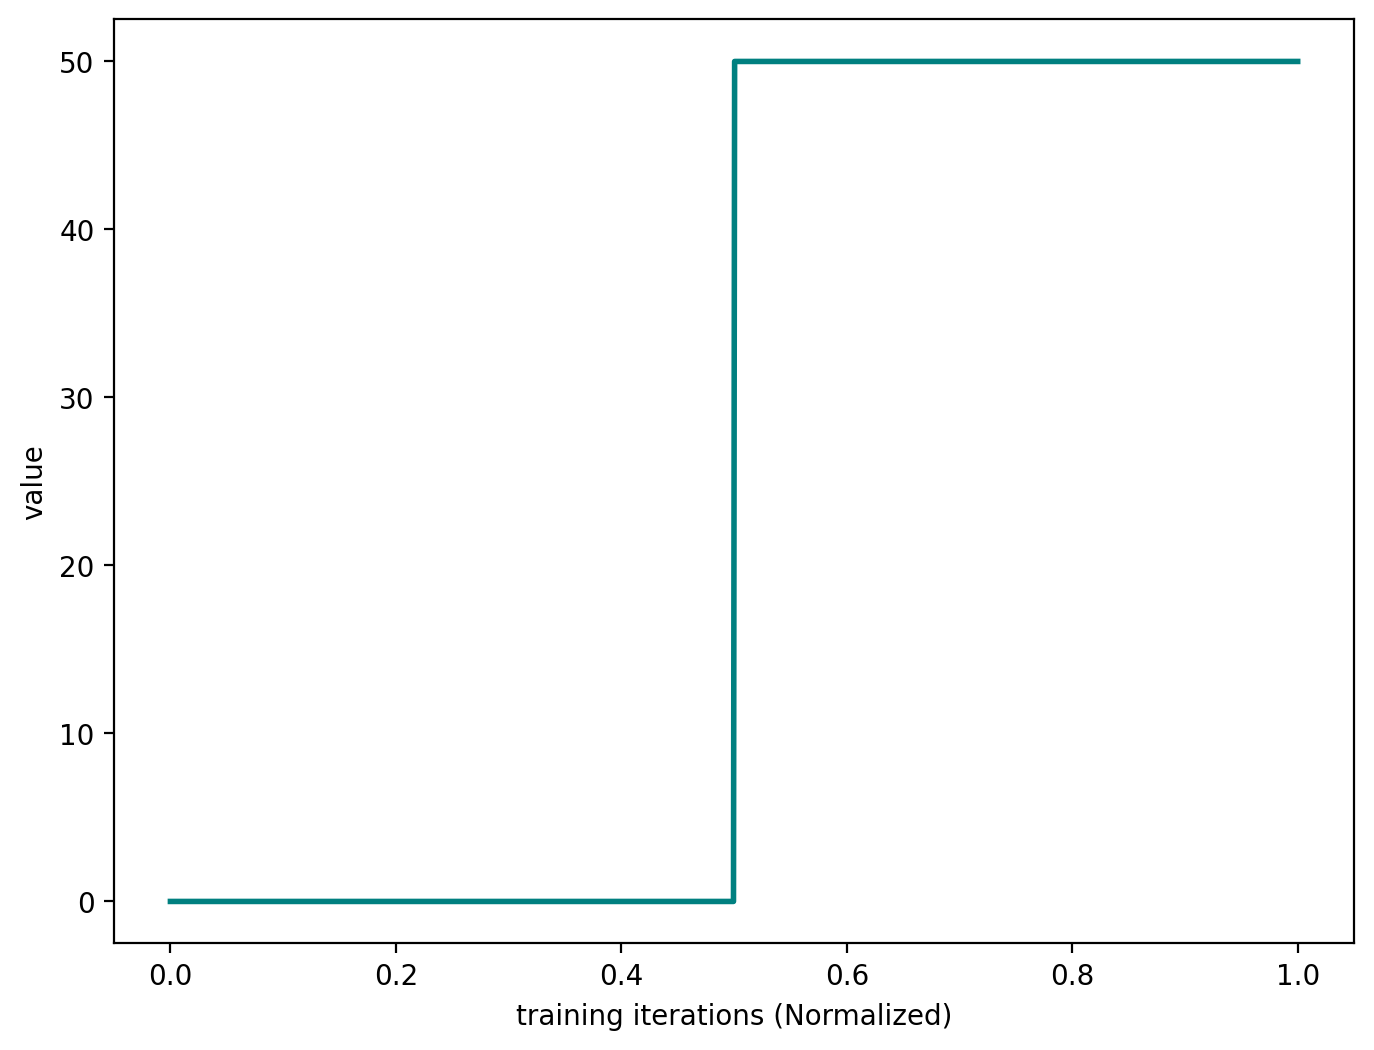

In [ ]:
#| output: false
one_shot.plot(50)

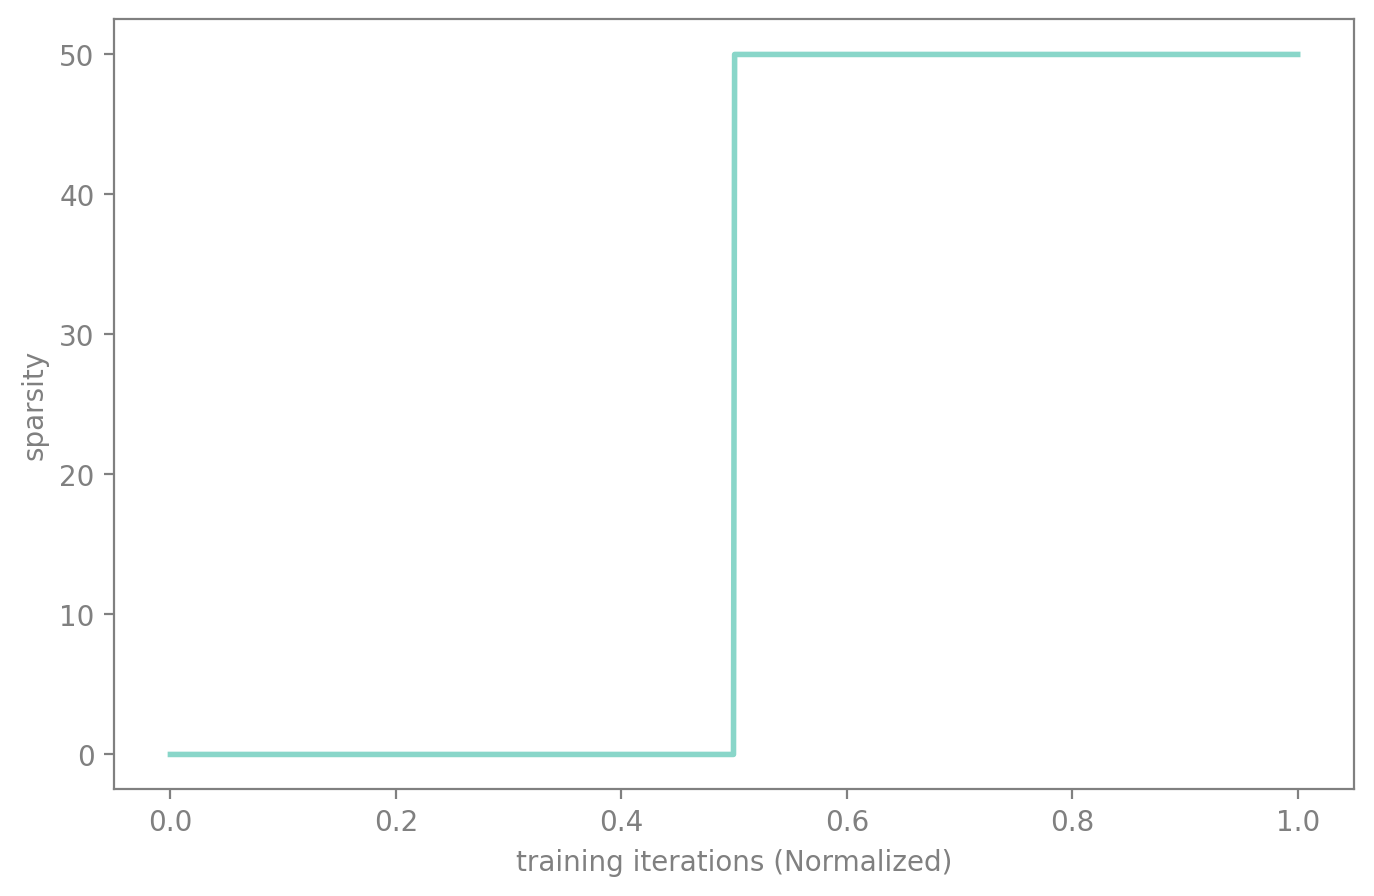

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [one_shot.progress(p) * 50 for p in prune]
one_shot.reset()
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

---

## Iterative

Instead of pruning the network to desired sparsity in one step, you can do it iteratively. In fasterai, you can change the amount of iterations

In [ ]:
#| export
def sched_iterative(
    start: float, # Starting sparsity level
    end: float,   # Target sparsity level
    pos: float,   # Current position in schedule (0-1)
    n_steps: int = 3  # Number of pruning steps
) -> float:
    "Perform iterative pruning in discrete steps"
    return start + ((end-start)/n_steps) * (np.ceil(pos * n_steps))

iterative = Schedule(sched_iterative, start_pct=0.2)

In [ ]:
show_doc(sched_iterative)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L92){target="_blank" style="float:right; font-size:smaller"}

### sched_iterative

```python

def sched_iterative(
    start:float, # Starting sparsity level
    end:float, # Target sparsity level
    pos:float, # Current position in schedule (0-1)
    n_steps:int=3, # Number of pruning steps
)->float:


```

*Perform iterative pruning in discrete steps*

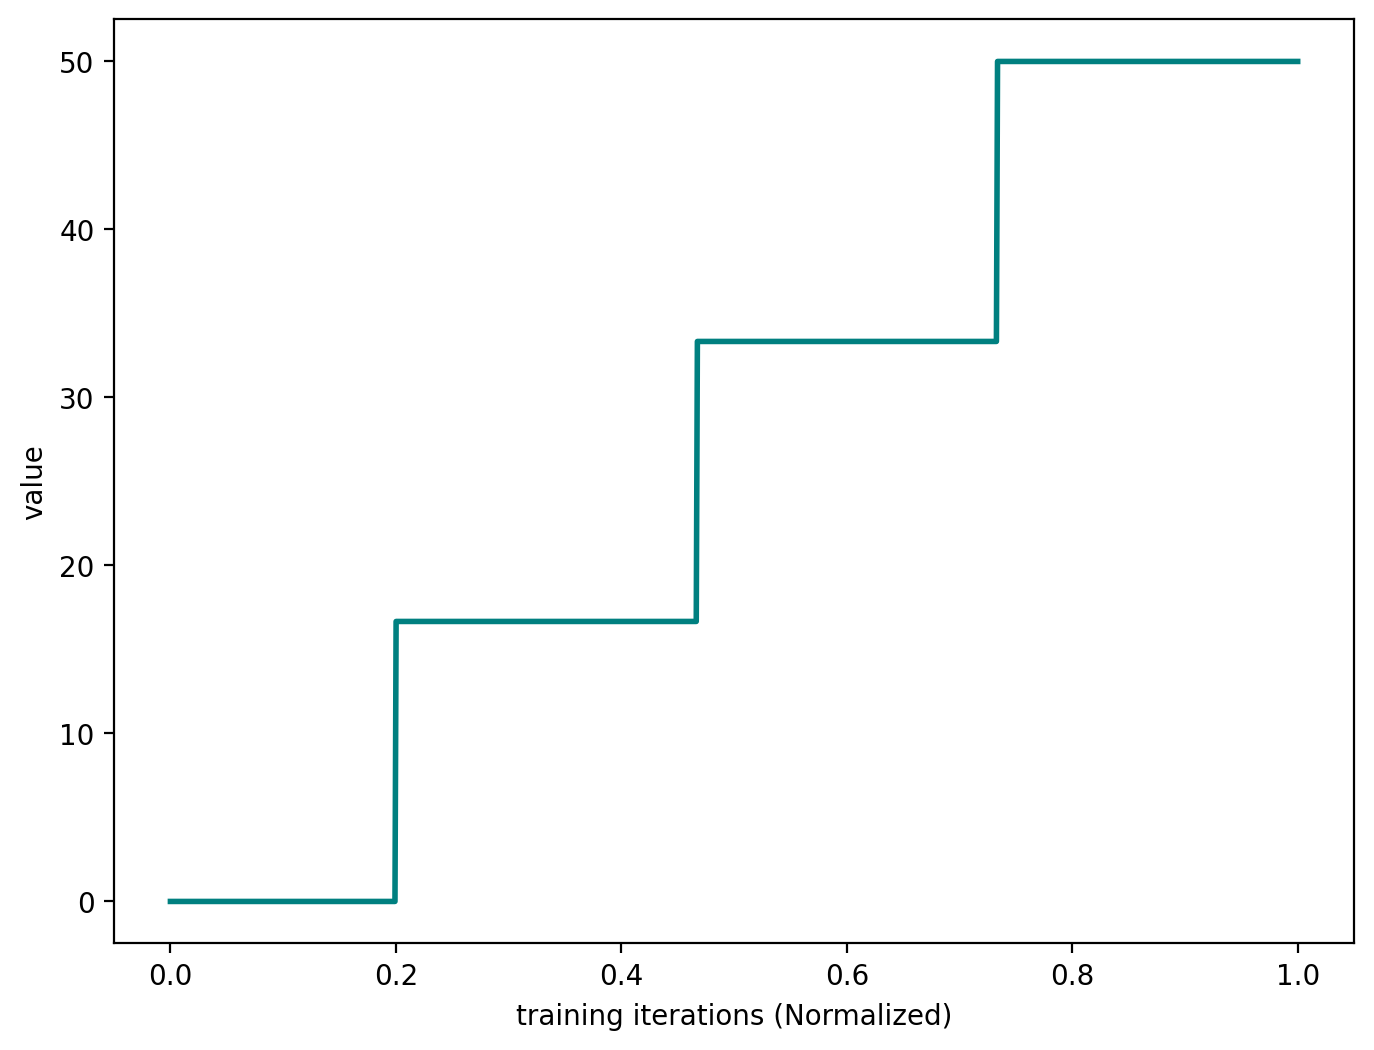

In [ ]:
#| output: false
iterative.plot(50)

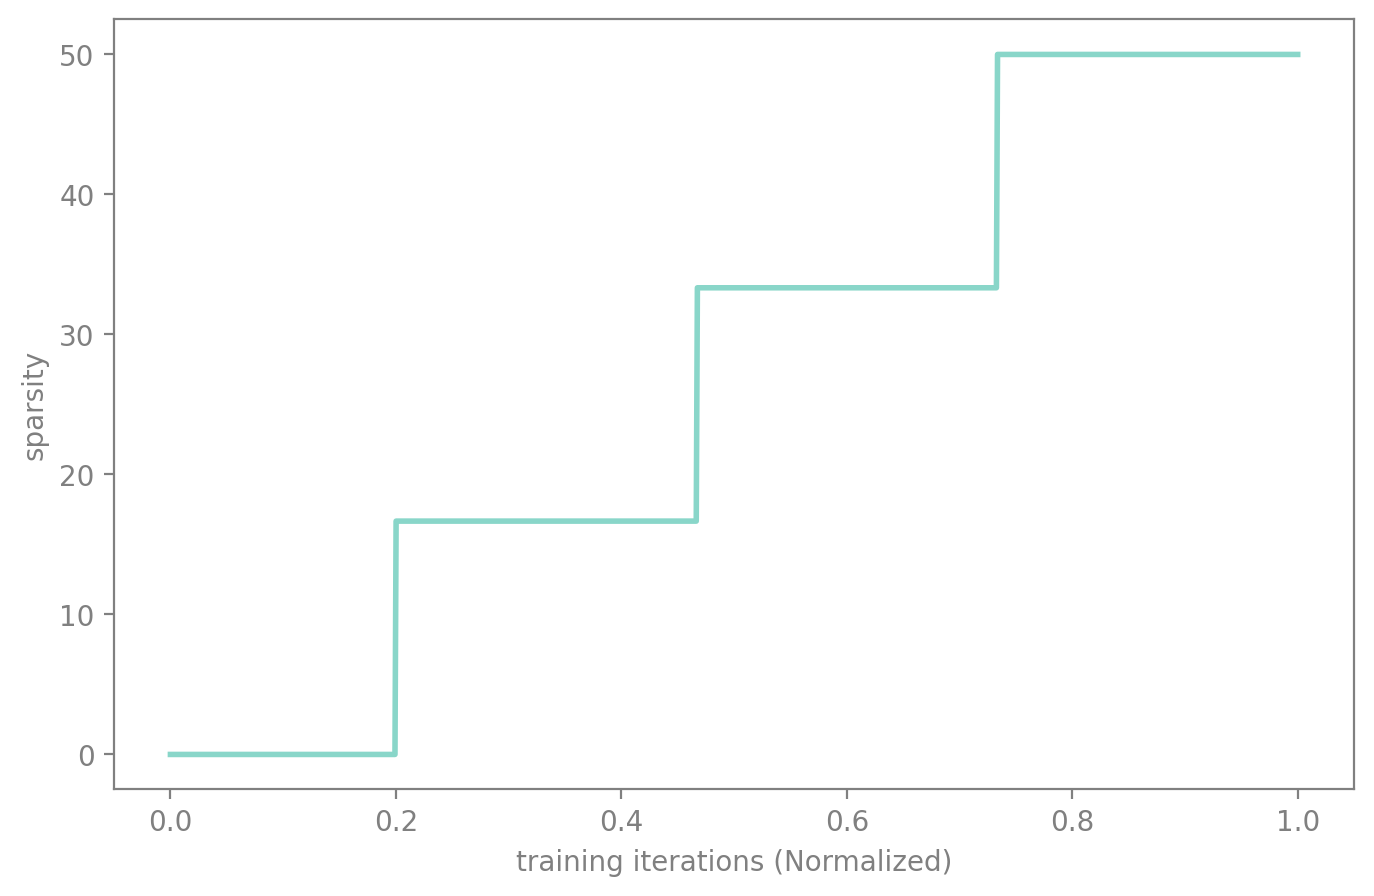

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [iterative.progress(p) * 50 for p in prune]
iterative.reset()
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

To modify the default `n_steps`, you can use the `partial` function.

In [ ]:
iterative = Schedule(partial(sched_iterative, n_steps=5), start_pct=0.2)

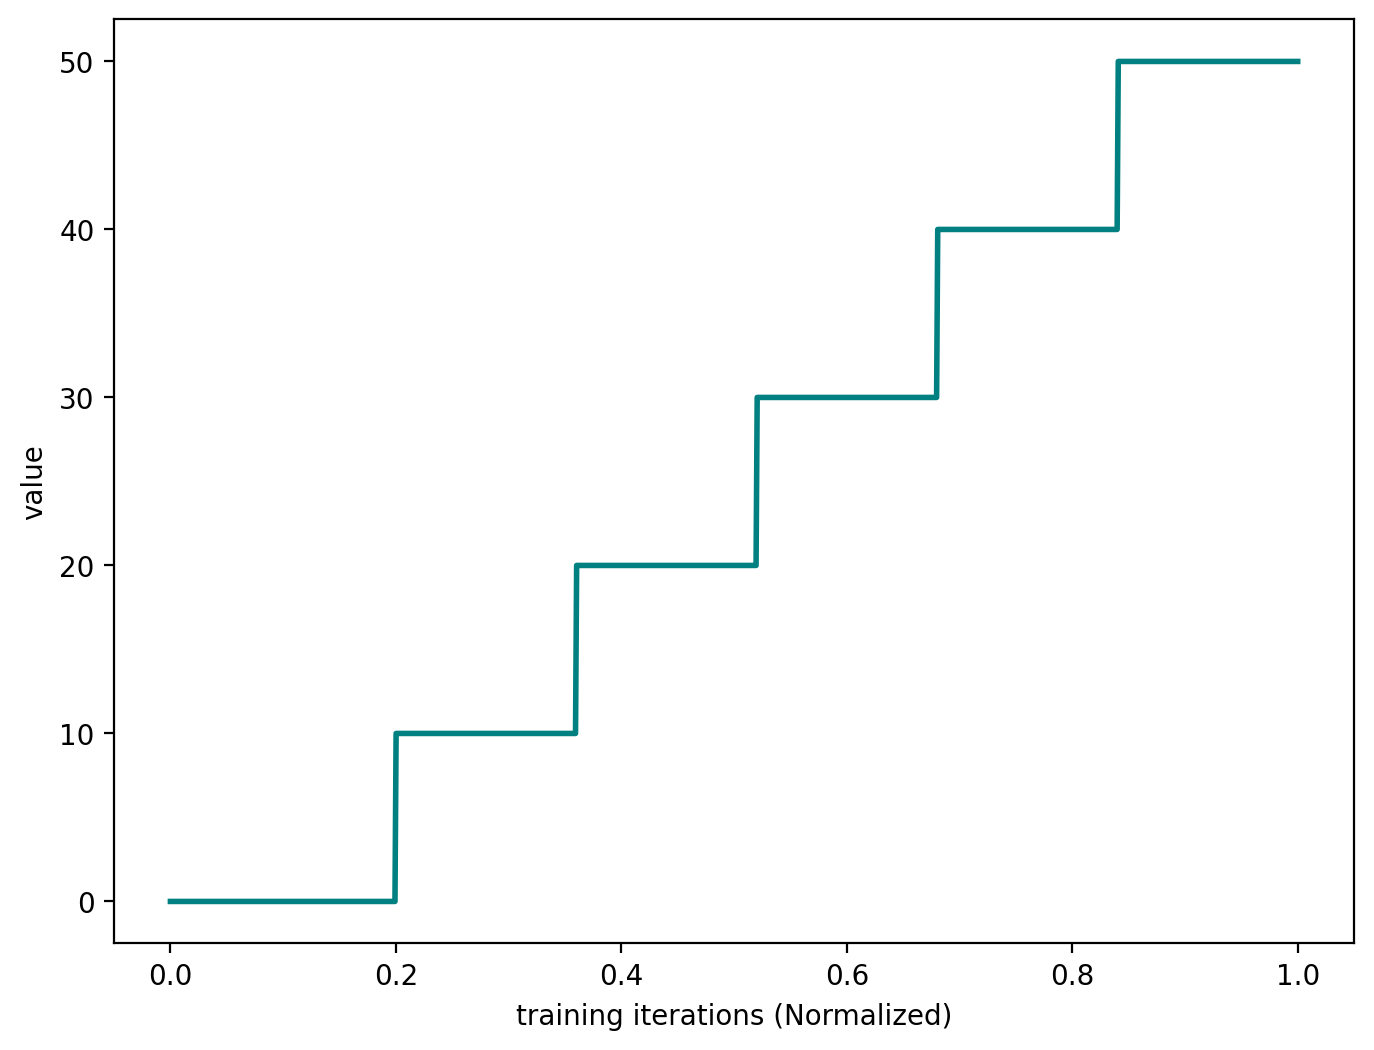

In [ ]:
#| output: false
iterative.plot(50)

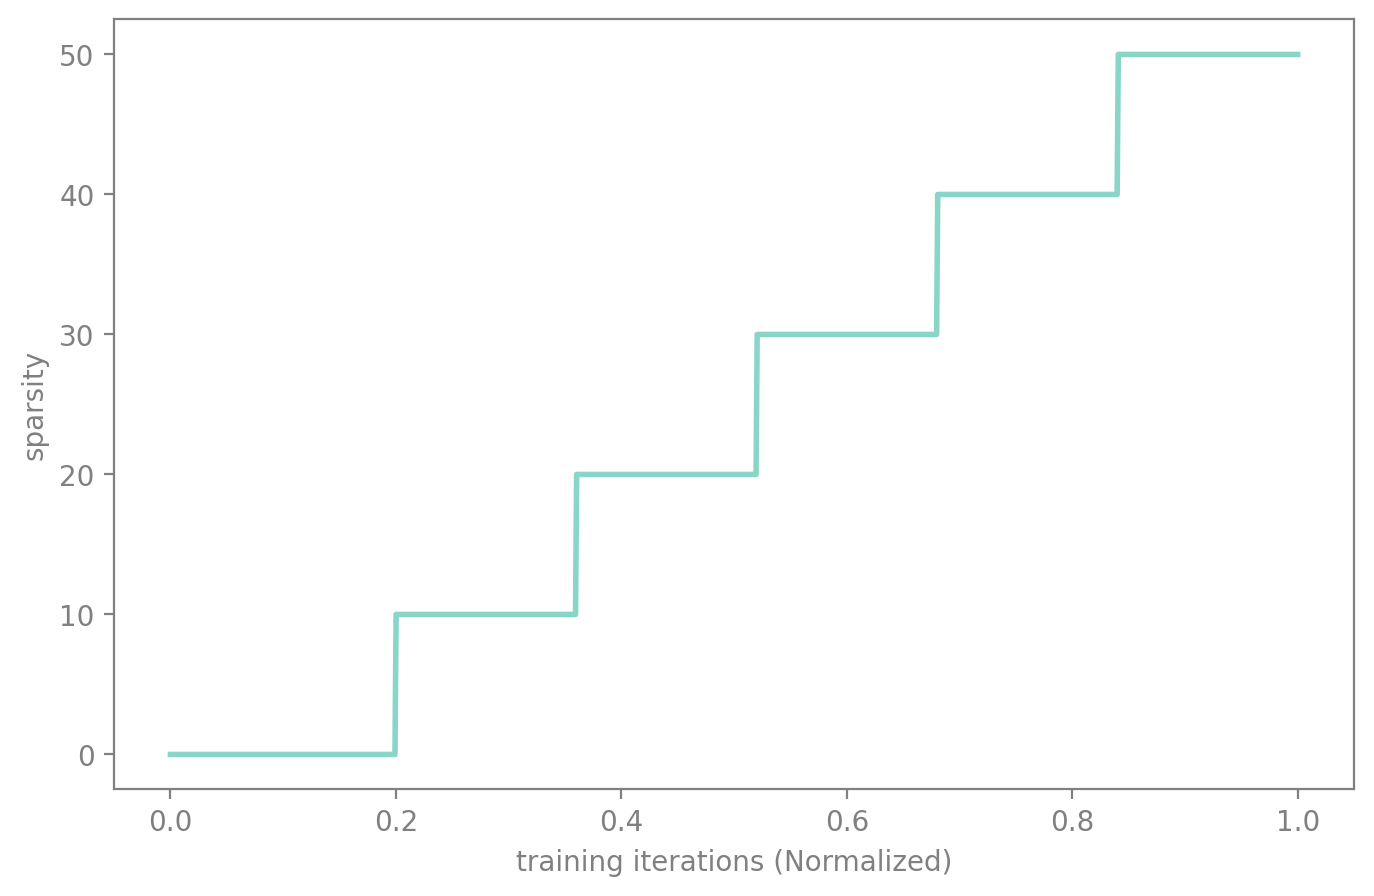

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [iterative.progress(p) * 50 for p in prune]
iterative.reset()
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

---

## Automated Gradual Pruning

Some researchers have come up with more sophisticated schedules, such as the [Automated Gradual Pruning](https://arxiv.org/abs/1710.01878).

In [ ]:
#| export
def sched_agp(
    start: float, # Starting sparsity level
    end: float,   # Target sparsity level
    pos: float    # Current position in schedule (0-1)
) -> float:
    "Automated gradual pruning schedule with cubic decay"
    return end + (start - end) * (1 - pos)**3

agp = Schedule(sched_agp, start_pct=0.2)

In [ ]:
show_doc(sched_agp)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L104){target="_blank" style="float:right; font-size:smaller"}

### sched_agp

```python

def sched_agp(
    start:float, # Starting sparsity level
    end:float, # Target sparsity level
    pos:float, # Current position in schedule (0-1)
)->float:


```

*Automated gradual pruning schedule with cubic decay*

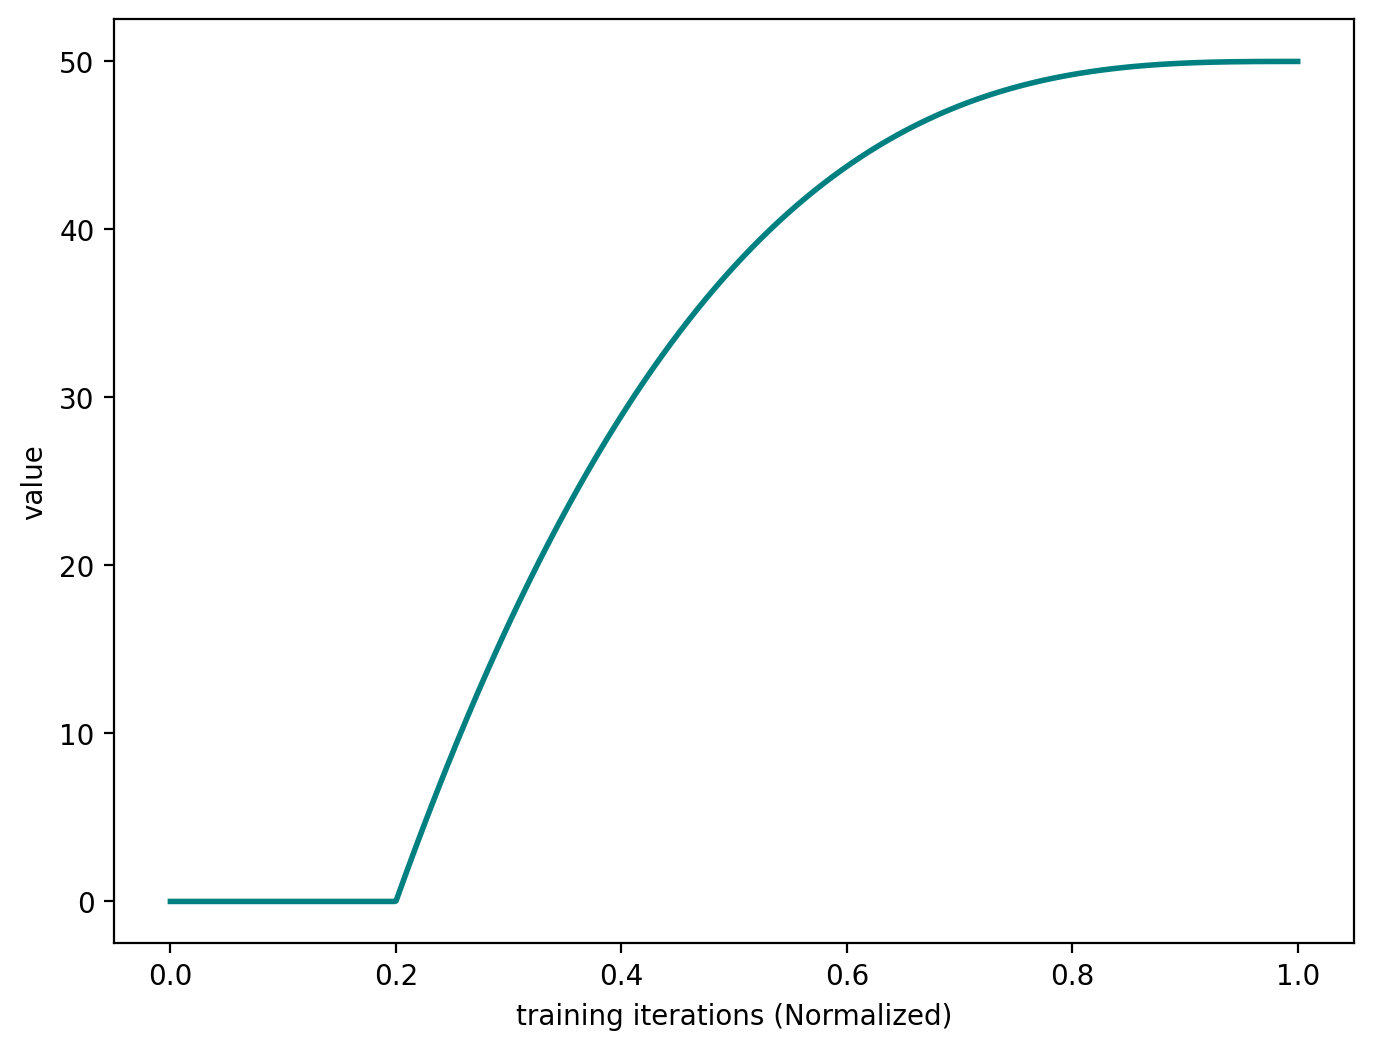

In [ ]:
agp.plot(50)

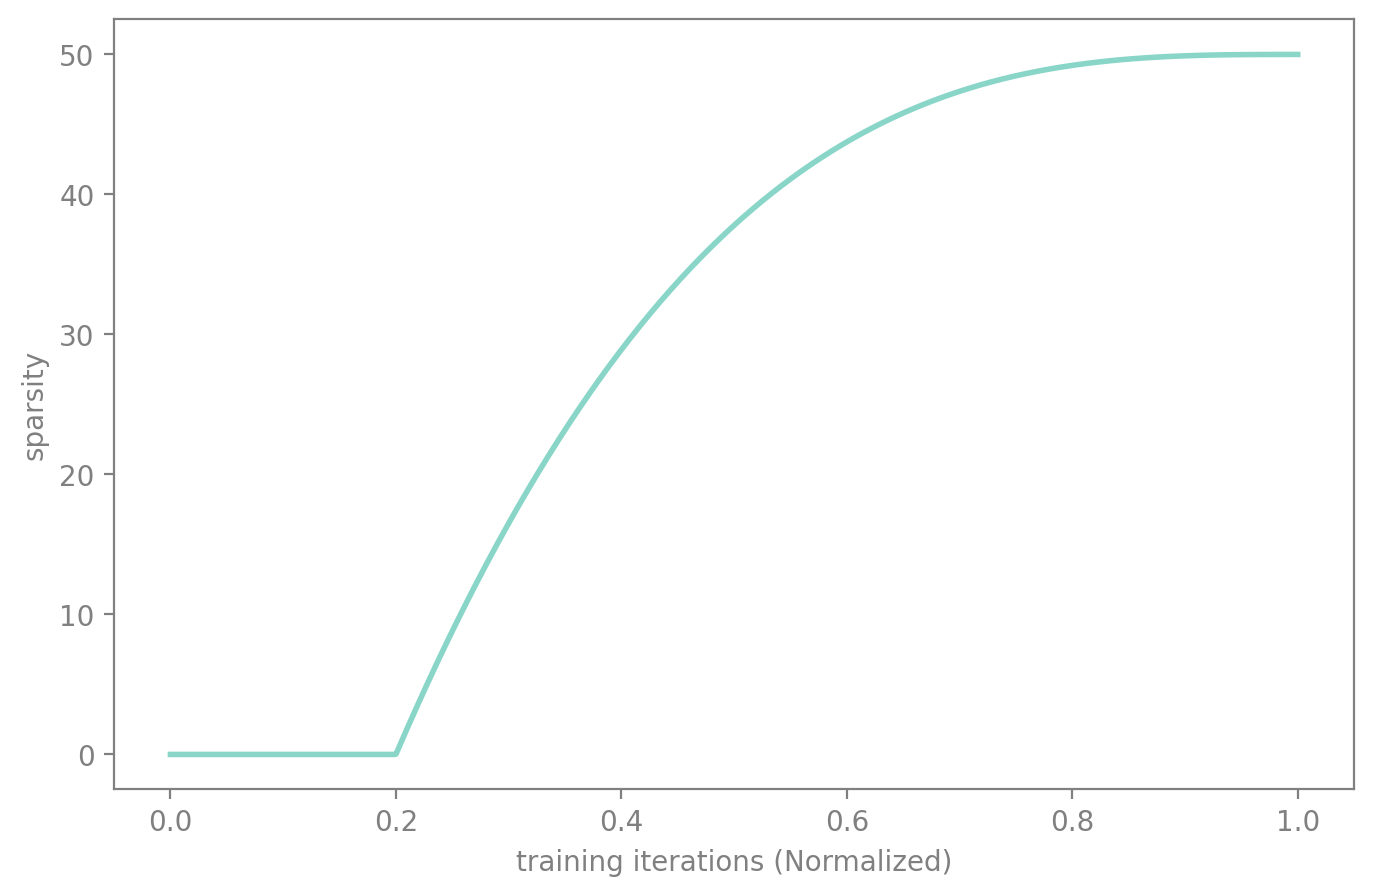

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [agp.progress(p) * 50 for p in prune]
agp.reset()
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

## One-Cycle Pruning

In [ ]:
#| export
def sched_onecycle(
    start: float,  # Starting sparsity level
    end: float,    # Target sparsity level
    pos: float,    # Current position in schedule (0-1)
    α: float = 14, # Steepness parameter
    β: float = 6   # Offset parameter
) -> float:
    "One-cycle schedule based on logistic function"
    out = (1+np.exp(-α+β)) / (1 + (np.exp((-α*pos)+β)))
    return start + (end-start)*out

one_cycle = Schedule(sched_onecycle)

In [ ]:
show_doc(sched_onecycle)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L115){target="_blank" style="float:right; font-size:smaller"}

### sched_onecycle

```python

def sched_onecycle(
    start:float, # Starting sparsity level
    end:float, # Target sparsity level
    pos:float, # Current position in schedule (0-1)
    α:float=14, # Steepness parameter
    β:float=6, # Offset parameter
)->float:


```

*One-cycle schedule based on logistic function*

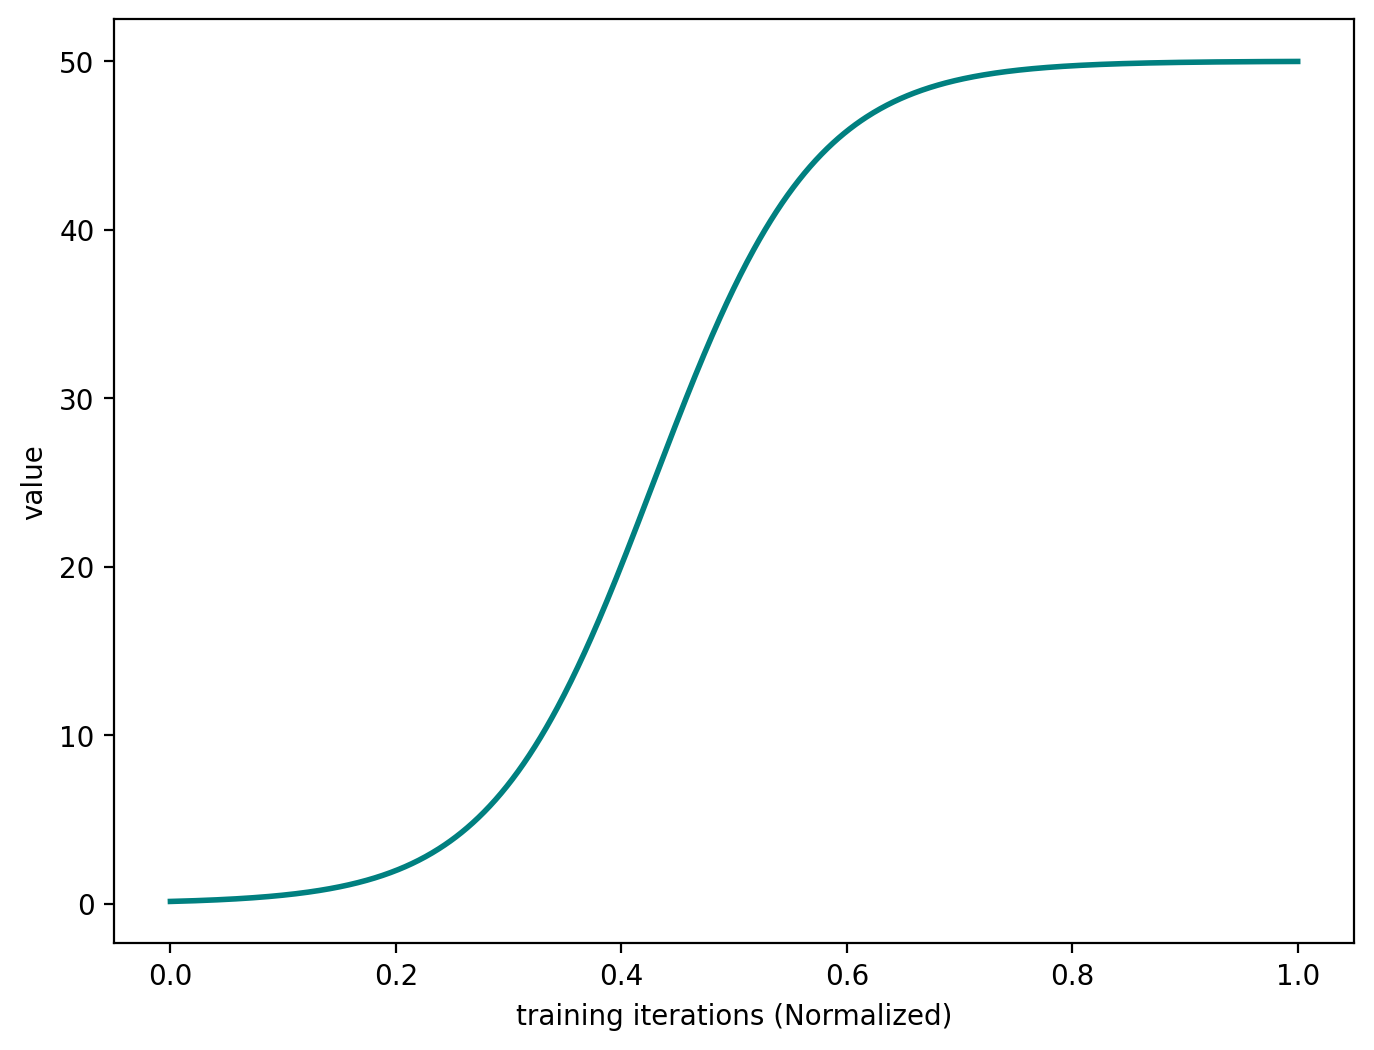

In [ ]:
#| output: false
one_cycle.plot(50)

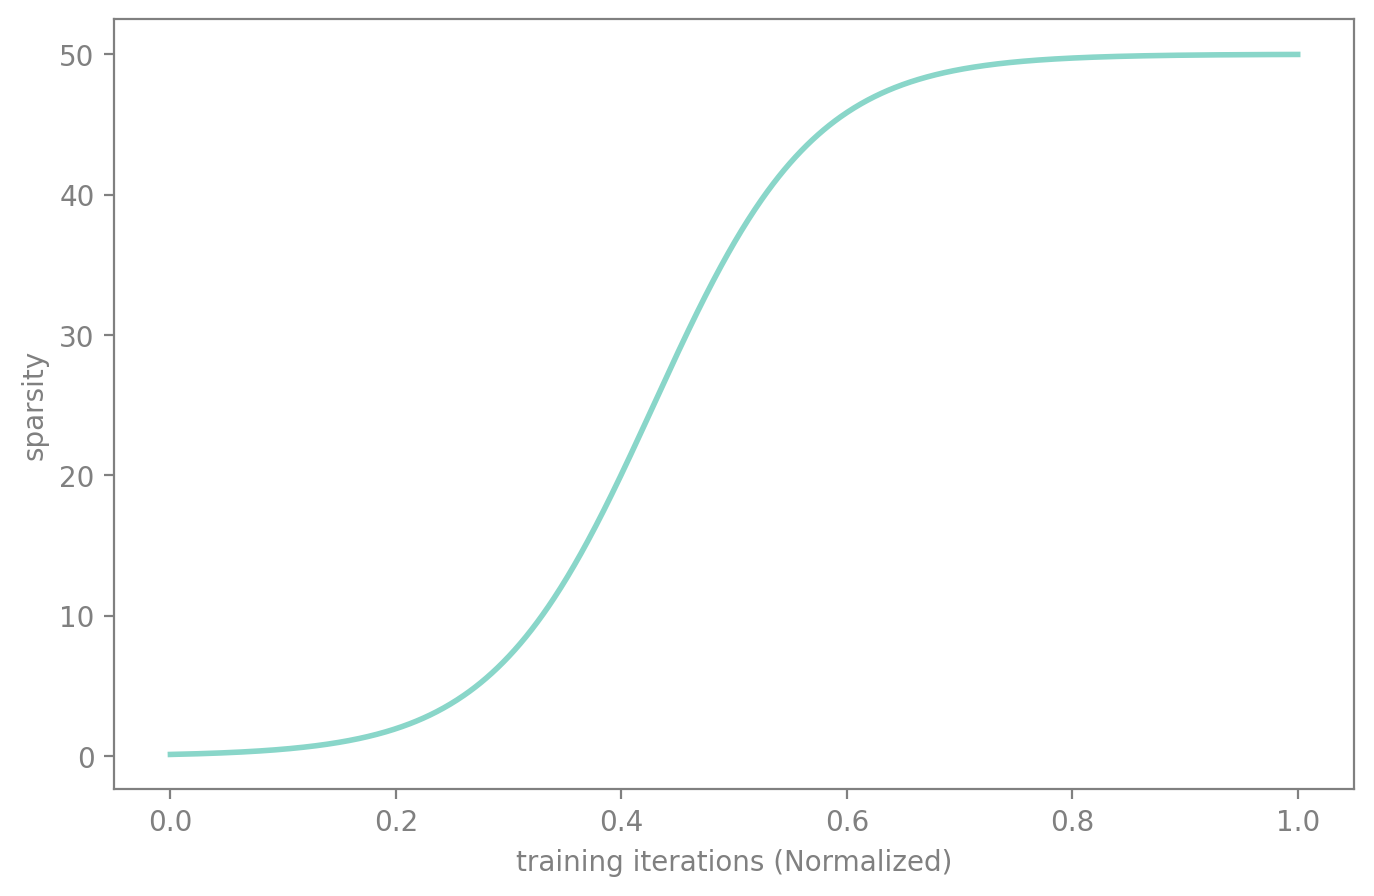

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [one_cycle.progress(p) * 50 for p in prune]
one_cycle.reset()
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

On top of that, all of the schedules available in fastai by default are also available:
- sched_cos
- sched_linear

In [ ]:
#| export
cos = Schedule(sched_cos)
lin = Schedule(sched_lin)

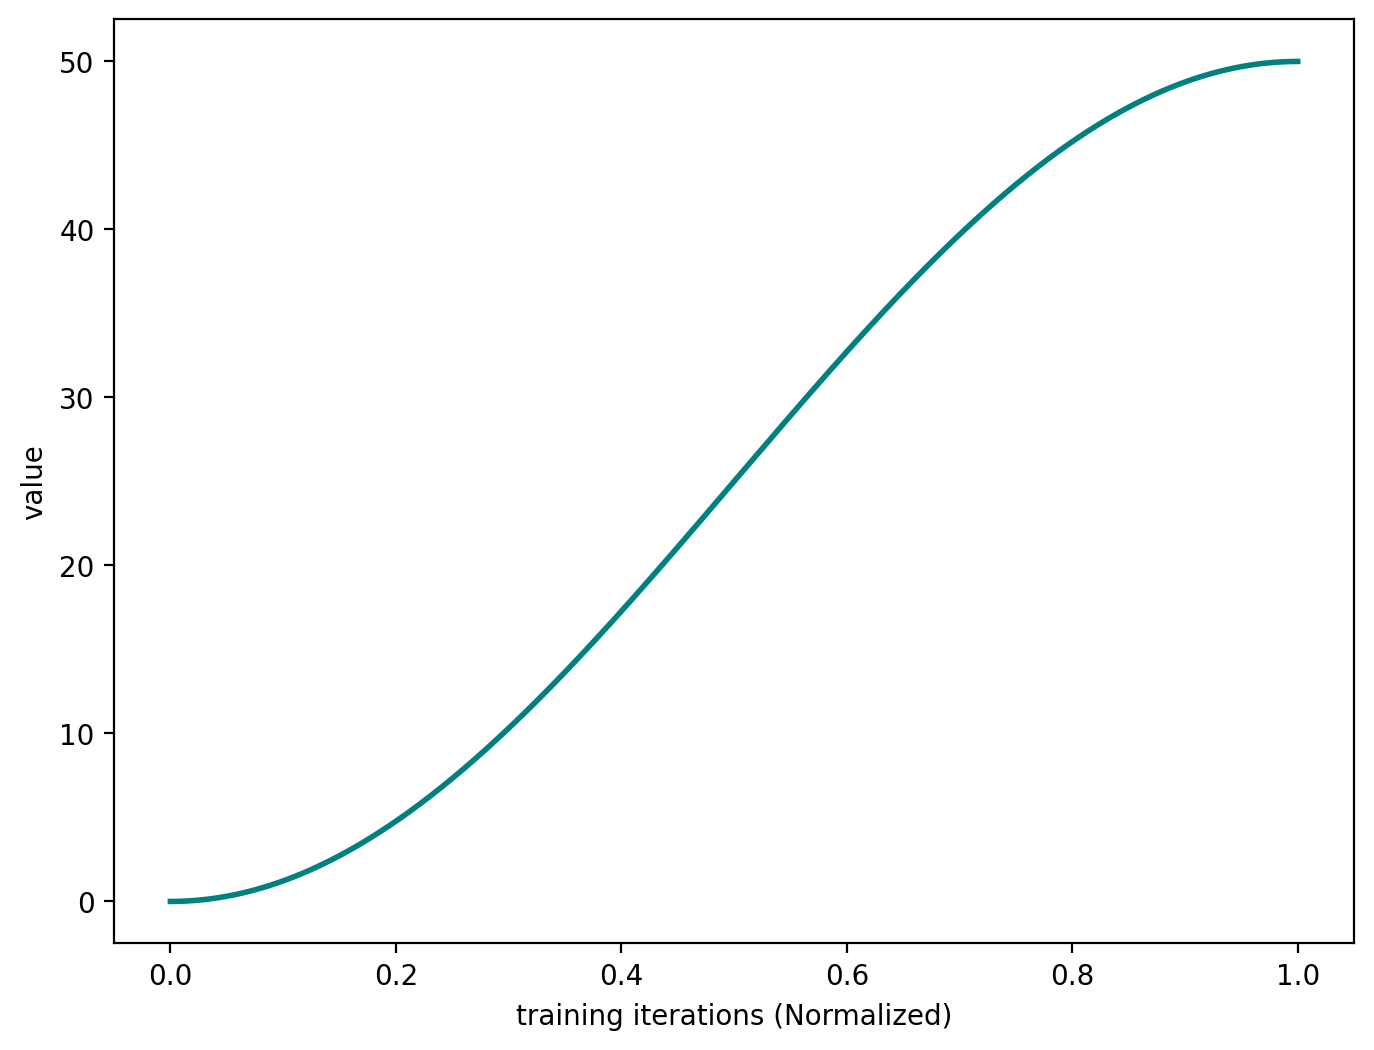

In [ ]:
#| output: false
cos.plot(50)

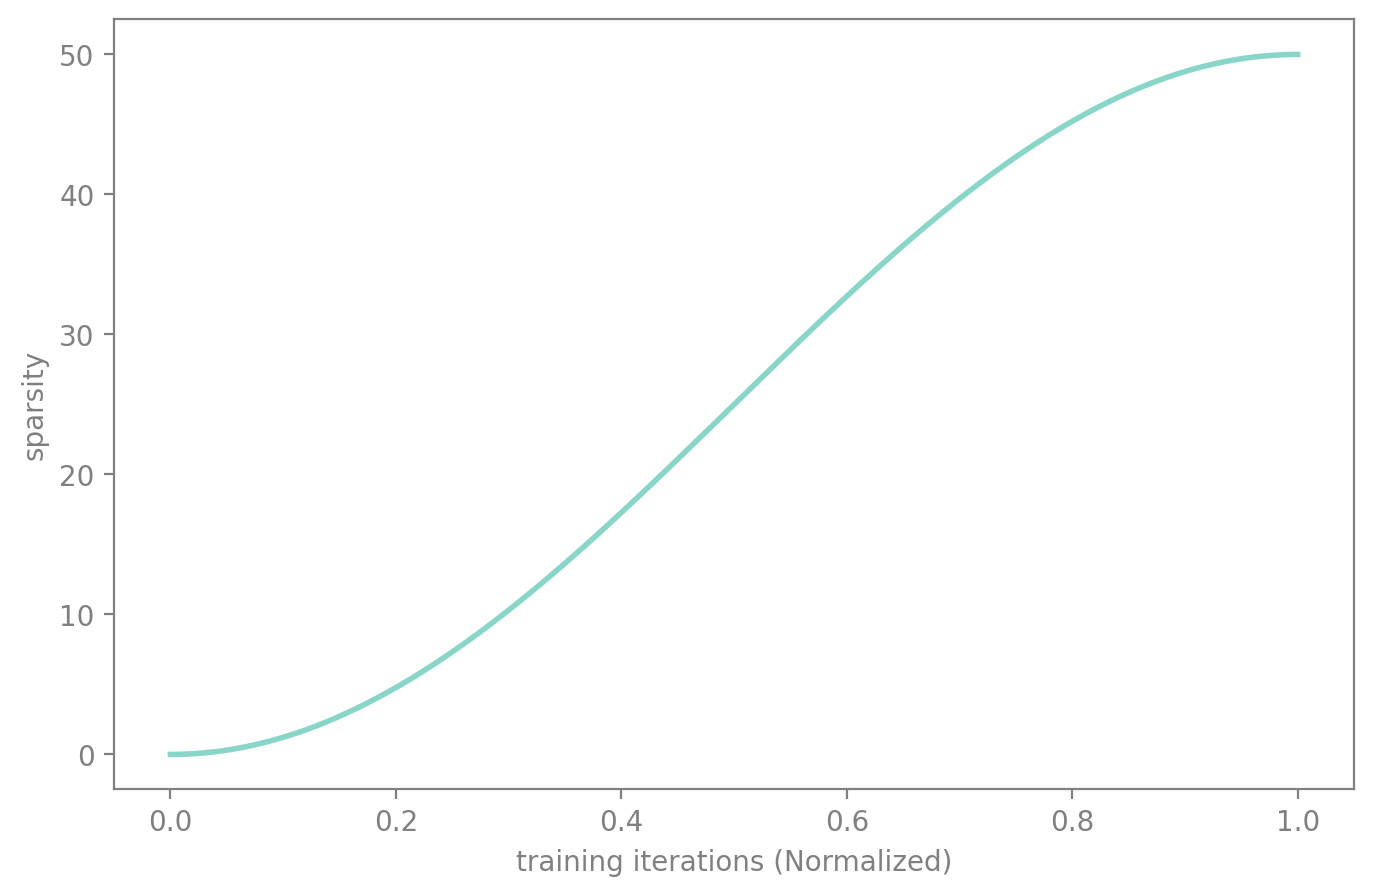

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [cos.progress(p) * 50 for p in prune]
cos.reset()
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

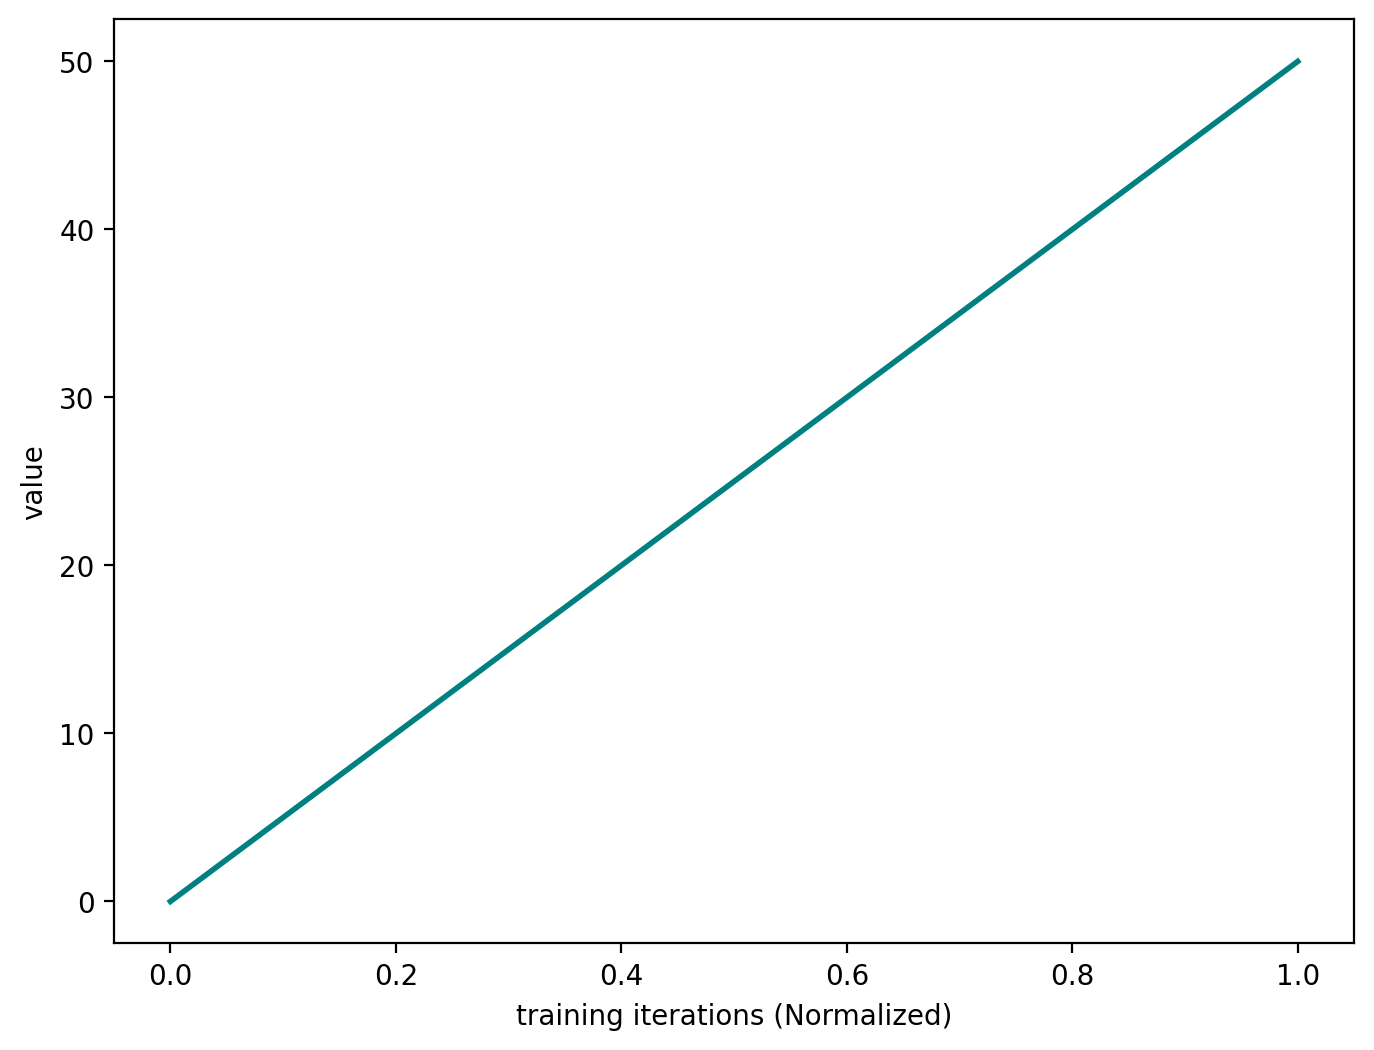

In [ ]:
#| output: false
lin.plot(50)

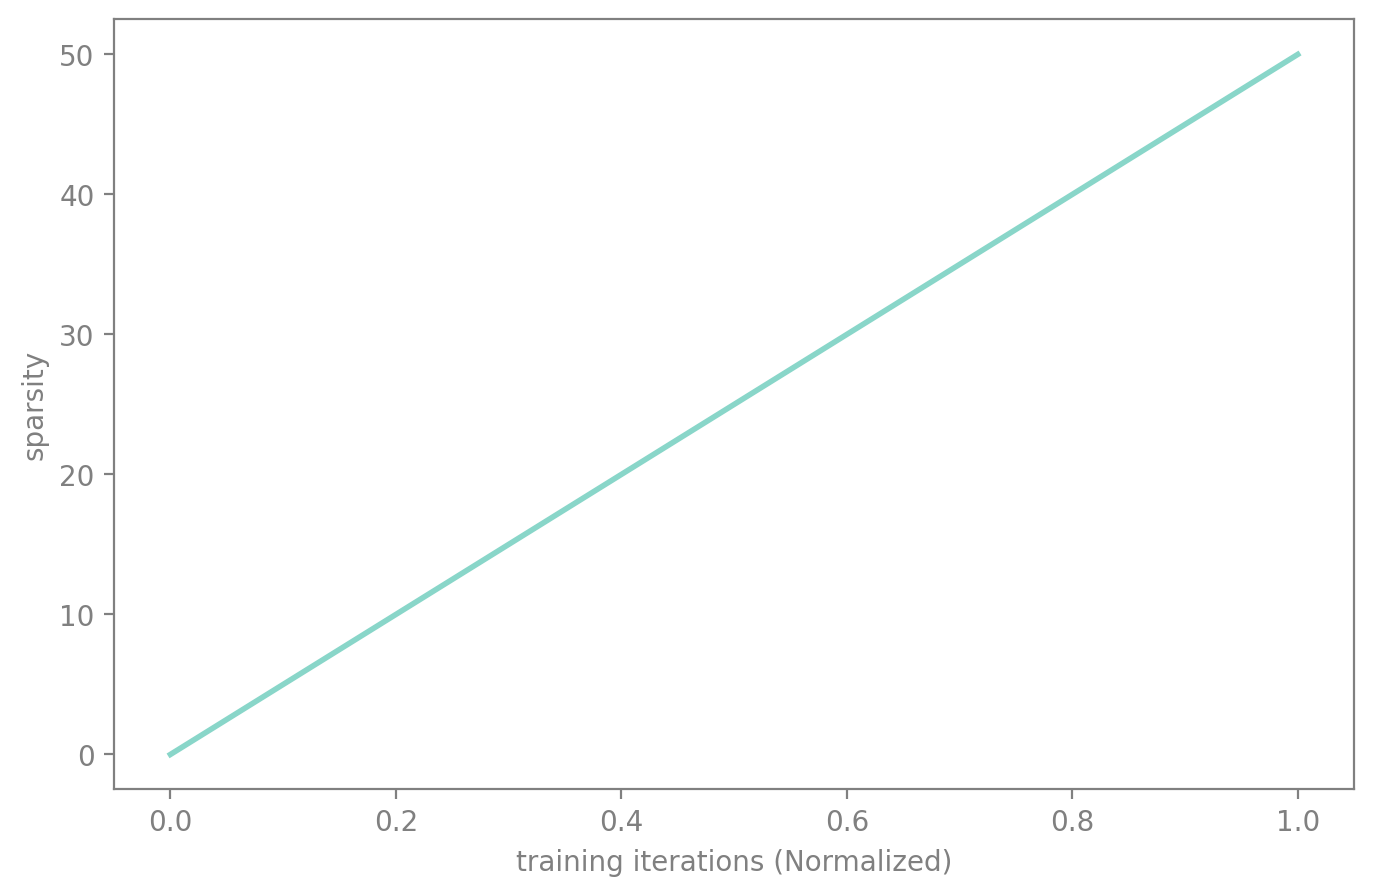

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [lin.progress(p) * 50 for p in prune]
lin.reset()
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

---

## Dense-Sparse-Dense

You can also create even more interesting behaviours such as the DSD method, where you prune the model in the first place, then re-grow it to its initial amount of parameter.

In [ ]:
#| export
def sched_dsd(
    start: float, # Starting sparsity level
    end: float,   # Target sparsity level
    pos: float    # Current position in schedule (0-1)
) -> float:
    "Dense-Sparse-Dense schedule: increase then decrease sparsity"
    if pos<0.5:
        return start + (1 + math.cos(math.pi*(1-pos*2))) * (end-start) / 2
    else:
        return end + (1 - math.cos(math.pi*(1-pos*2))) * (start-end) / 2
    
dsd = Schedule(sched_dsd)

In [ ]:
show_doc(sched_dsd)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L133){target="_blank" style="float:right; font-size:smaller"}

### sched_dsd

```python

def sched_dsd(
    start:float, # Starting sparsity level
    end:float, # Target sparsity level
    pos:float, # Current position in schedule (0-1)
)->float:


```

*Dense-Sparse-Dense schedule: increase then decrease sparsity*

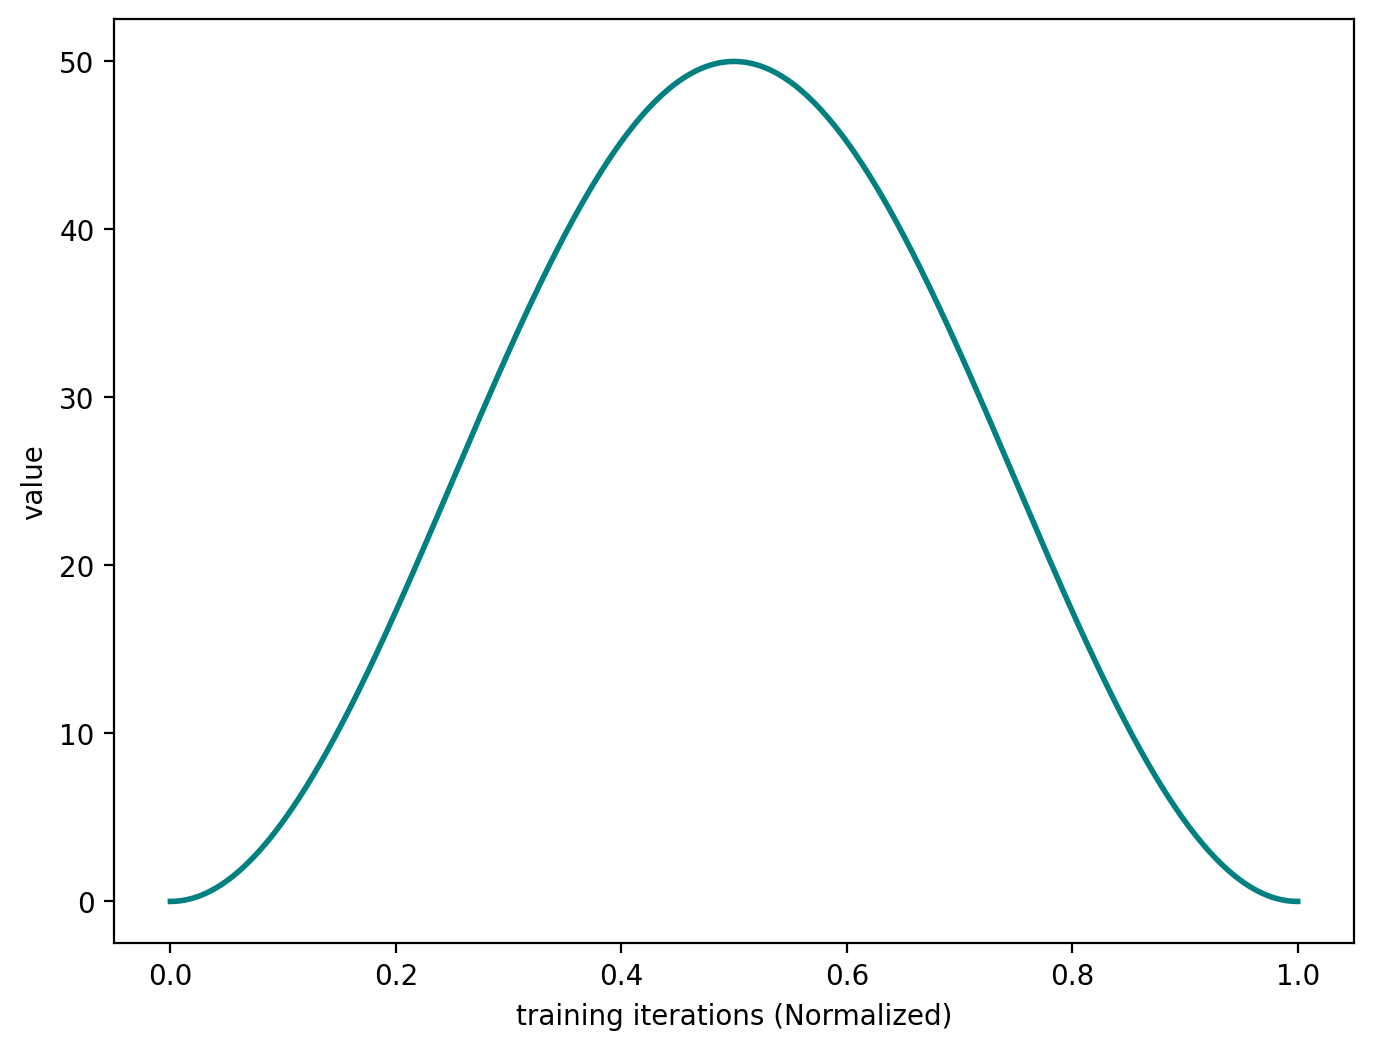

In [ ]:
#| output: false
dsd.plot(50)

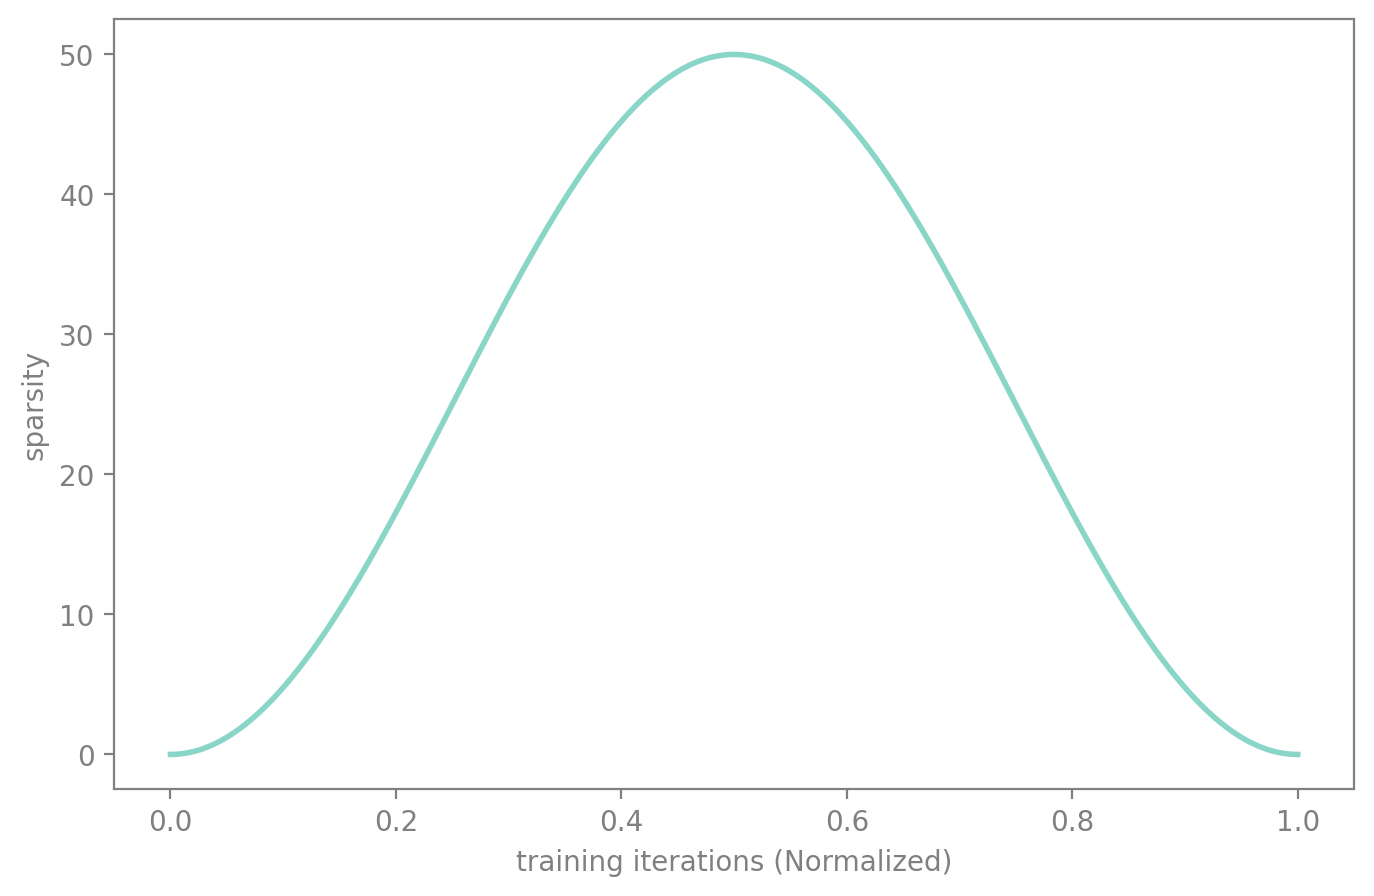

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [dsd.progress(p) * 50 for p in prune]
#dsd.reset()
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

---

## Composing Schedules

By default, `progress()` returns values in `[0, 1]`. But with `start_val` and `end_val`, you can control the output range of each schedule, making it easy to chain them together for multi-phase training.

For example, say you want to:

1. **Phase 1** (0%–40% of training): ramp sparsity from 0% to 30% using AGP
2. **Phase 2** (40%–70% of training): ramp sparsity from 30% to 50% using cosine
3. **Phase 3** (70%–100% of training): hold at 50%

Each schedule maps its `[start_val, end_val]` to a portion of the overall progress. The callback still just computes `target * progress` — the composition is entirely in the schedule definitions.

In [ ]:
composed = [
    Schedule(sched_agp, start_pct=0.0, end_pct=0.4, start_val=0.0, end_val=0.6),  # 0→60% of target
    Schedule(sched_cos, start_pct=0.4, end_pct=0.7, start_val=0.6, end_val=1.0),  # 60→100% of target
    # Phase 3: no schedule needed — last schedule holds at end_val after end_pct
]

<matplotlib.legend.Legend>

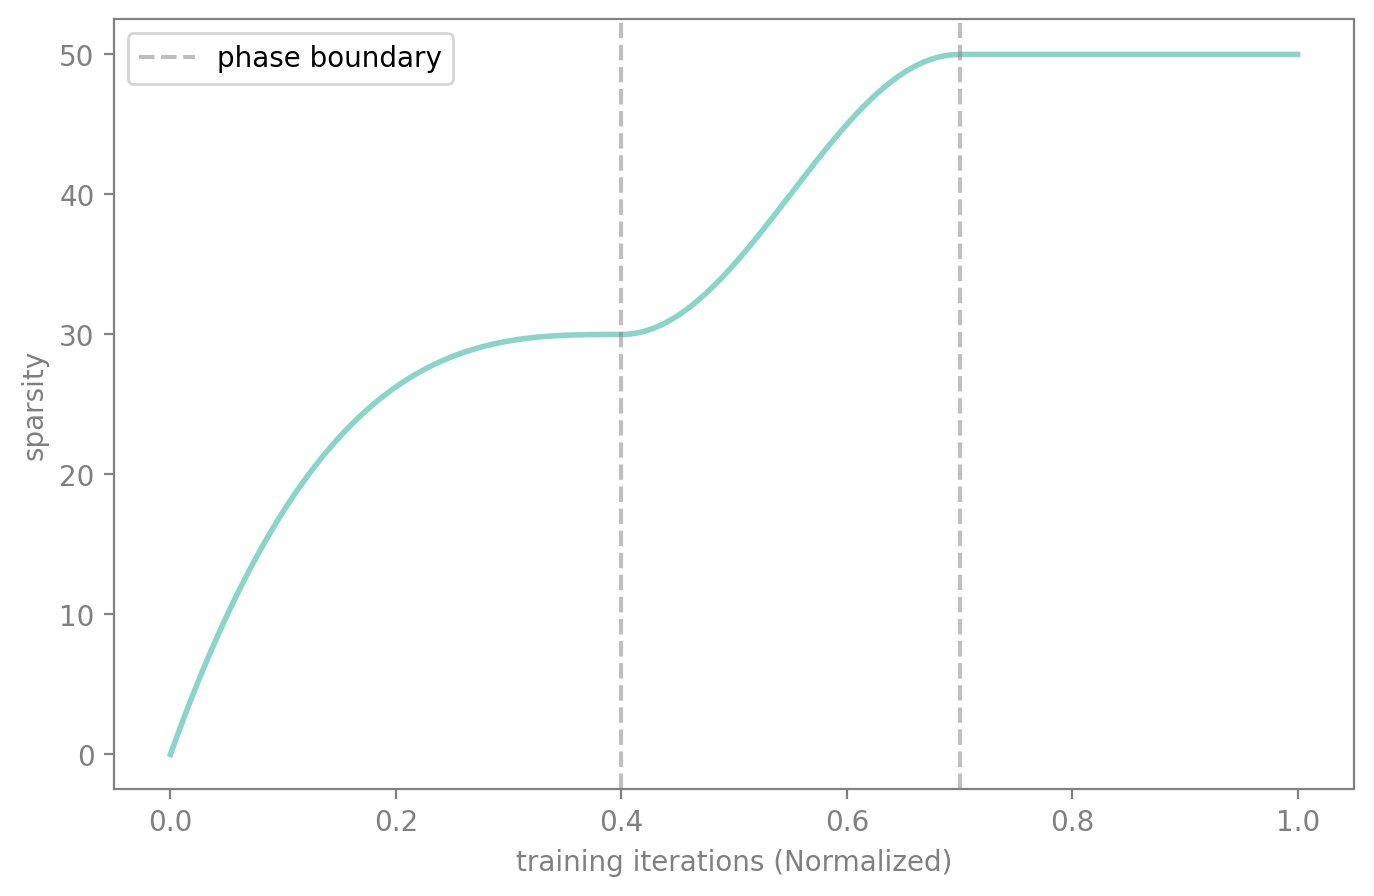

In [ ]:
#| echo: false
def composed_progress(schedules, pct):
    "Get progress from the active schedule at a given training percentage"
    for s in reversed(schedules):
        if pct >= s.start_pct:
            return s.progress(pct)
    return schedules[0].progress(pct)

fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

target = 50
pcts = np.linspace(0, 1, 1000)
values = [composed_progress(composed, p) * target for p in pcts]
for s in composed: s.reset()

plt.plot(pcts, values, c='#89d6c9', linewidth=2)
plt.axvline(x=0.4, color='#808080', linestyle='--', alpha=0.5, label='phase boundary')
plt.axvline(x=0.7, color='#808080', linestyle='--', alpha=0.5)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')
plt.legend()

The first schedule (AGP) ramps progress from `0.0` to `0.6`, so `target * progress` goes from 0% to 30%. The second schedule (cosine) picks up at `0.6` and continues to `1.0`, taking sparsity from 30% to 50%. After the last schedule's `end_pct`, the progress holds at `end_val` — giving us the hold phase for free.

In [ ]:
#| export
schedules = ('one_shot', 'iterative', 'agp', 'one_cycle', 'cos', 'lin', 'dsd')
def available_schedules() -> list[str]:
    "Return list of available pruning schedules"
    return list(schedules)

In [ ]:
#| hide
from fastcore.test import *

# one_shot (start_pct=0.5): 0 before start, jumps to 1 at start
test_eq(one_shot.progress(0.0), 0.0)
test_eq(one_shot.progress(0.49), 0.0)
test_close(one_shot.progress(1.0), 1.0, eps=1e-6)
one_shot.reset()

# agp (start_pct=0.2): cubic at pct=0.5
# normalized pos = (0.5 - 0.2) / (1.0 - 0.2) = 0.375
# agp formula: 0 + (0 - 1) * (1 - 0.375)^3 = 1 - 0.625^3 ≈ 0.756
test_close(agp.progress(0.5), 0.756, eps=0.01)
agp.reset()

# cos: at midpoint ≈ 0.5
test_close(cos.progress(0.5), 0.5, eps=0.05)
cos.reset()

# lin: linear → 0.5 at midpoint
test_close(lin.progress(0.5), 0.5, eps=1e-6)
lin.reset()

# changed property tracks state transitions
sched = Schedule(sched_lin)
_ = sched.progress(0.0)
test_eq(sched.changed, False)  # 0→0, no change
_ = sched.progress(0.5)
test_eq(sched.changed, True)  # 0→0.5, changed
sched.after_step()
test_eq(sched.changed, False)  # previous updated
sched.reset()

# reset restores initial state
sched2 = Schedule(sched_lin)
_ = sched2.progress(0.8)
sched2.reset()
test_eq(sched2._current_progress, 0.0)
test_eq(sched2._previous_progress, 0.0)

# Custom start_pct
late = Schedule(sched_lin, start_pct=0.5)
test_eq(late.progress(0.0), 0.0)   # before start
test_eq(late.progress(0.49), 0.0)  # still before start
test_close(late.progress(0.75), 0.5, eps=0.01)
late.reset()

# available_schedules returns list
scheds = available_schedules()
assert 'one_shot' in scheds
assert 'agp' in scheds
assert 'cos' in scheds
assert len(scheds) > 0

# dsd returns to 0 at end
test_close(dsd.progress(1.0), 0.0, eps=1e-6)
dsd.reset()

---

## See Also

- [SparsifyCallback](../sparse/sparsify_callback.html) - Apply sparsification during training using these schedules
- [PruneCallback](../prune/prune_callback.html) - Apply structured pruning during training
- [Criteria](criteria.html) - Different importance measures for selecting what to prune